In [4]:
%matplotlib inline
import matplotlib
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import sys
sys.path.append('../../build')
import libry as lry
import time
import copy

In [5]:
# Load config, file and viewer
K = lry.Config()
K.clear()
K.addFile('pegArm.g')
K.sortFrames()
D = K.view()

**ry-c++-log** /home/levinz/Desktop/git/robotics-course/rai/rai/Core/graph.cpp:readNode:896(-1) you specified tags [contact, color] for node 'color:[0, 0.5, 0]', which is of non-graph type -- ignored



In [6]:
# Initialize variables, set start state
def init():
    global noise
    global gravity
    global n
    global tau
    global N
    global T

    global qdot
    global q
    global q_goal
    global q0
    global q_hist
    
    noise = .01
    gravity = True
    n = K.getJointDimension()
    tau = .01
    N = 500
    T = N*tau

    qdot = np.zeros(n)
#     q = np.zeros(n) + np.pi
    q = [np.pi, 0, 0]

    K.setJointState(q)

    q_goal = np.zeros(n)
    q0 = copy.deepcopy(q)

    q_hist = np.zeros((N, n))

In [7]:
def func(T, t, q, q_T):
        return q + 0.5*(1-np.cos(np.pi*t/T))*(q_T-q)

In [8]:
def func_dot(T, t, q, q_T):
        return -(1.5708*(q-q_T)*np.sin(np.pi*t/T))/T

In [9]:
def func_dotdot(T, t, q, q_T):
        return (4.9348*(q_T-q)*np.cos(np.pi*t/T))/(T*T)

In [12]:
init()
integration_error = 0
K_p=np.array([50, 25, 13])
K_d=np.array([30, 23, 13])
K_i=np.array([1, 1, 0.5])

for i in range(N):
    t = i * tau
    u = np.zeros(n)  # no controller torques 
    
    # b) compute desired position, velocity and acceleration with sine motion profile
    p_star = func(T,t,q,q_goal)
    v_star = func_dot(T,t,q,q_goal)
    a_star = func_dotdot(T,t,q,q_goal)
    
    # c) PD controller
    
    u = K_p * (p_star - q) + K_d * (v_star - qdot)

    # d) PID controller
    
    integration_error += (p_star - q)
    u += K_i * integration_error
    
    # e) Inverse dynamics feedforward control
    M, F = K.equationOfMotion(qdot, gravity)
    
    u = M @ a_star + F + (p_star - q) + (v_star - qdot)
    
    # dynamic simulation (simple Euler integration of the system dynamics, look into the code)
    qdot = K.stepDynamics(qdot, u, tau, noise, gravity)
    time.sleep(tau)
    q = K.getJointState()
    # print (" t=" + str(tau*t) + "sec E=" + str(K.getEnergy(qdot)) + "  q = " + str(q))
    q_hist[i] = q    

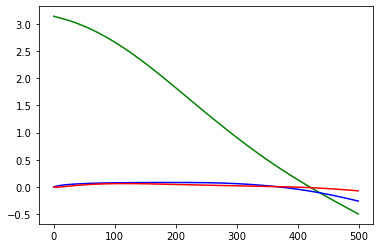

In [11]:
# plot q
plt.plot(q_hist[:,0], color="green")
plt.plot(q_hist[:,1], color="blue")
plt.plot(q_hist[:,2], color="red")
plt.show()